In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jaxley as jx

from jaxley import Compartment
from jaxley_mech.channels.tfmc90 import Phototransduction
from jaxley_mech.utils import prettify

In [2]:
META = {
    "cell_type": "rod",
    "species": "salamander (Ambystoma tigrinum)",
    "reference": [
        "Torre, V., Forti, S., Menini, A., & Campani, M. (1990). Model of Phototransduction in Retinal Rods. Cold Spring Harbor Symposia on Quantitative Biology, 55(0), 563–573. https://doi.org/10.1101/SQB.1990.055.01.054",
        "Kamiyama, Y., Wu, S. M., & Usui, S. (2009). Simulation analysis of bandpass filtering properties of a rod photoreceptor network. Vision Research, 49(9), 970–978. https://doi.org/10.1016/j.visres.2009.03.003",
    ],
    "note": "The model is from Torre et al. (1990) but variable naming convention and default parameters are from Kamiyama et al. (2009).",
}

## Liu & Kourennyi (2006)

Here, we reproduced TEA-induced oscillatory action potentials in rods under "dark" current conditions, which were disrupted by two 20 ms light pulses over 30 seconds (Liu & Kourennyi, 2006). Unlike the Liu paper, which used precomputed photocurrent, we simulated the photocurrent via the phototransduction channel (Torre, et al., 1990).

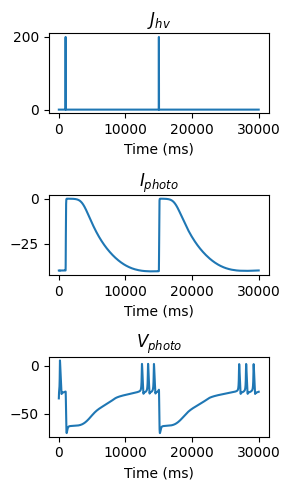

In [3]:
from jaxley_mech.channels.lk04 import Leak, Kx, Kv, Ca, CaPump, CaNernstReversal, KCa, ClCa, Hyper

params = {
    "length": 10,
    "radius": 5,
    "capacitance": 30.0,
    "axial_resistivity": 34.5,
    "v": -34,

    "Leak_gLeak": 0.52e-3,
    "Leak_eLeak": -74,

    "eK": -74,
    "Kv_gKv": 1e-3,
    "Kx_gKx": 0.45e-3,

    "CaPump_depth": 10,
    "CaPump_taur": 20, 
    "CaPump_cainf": 5e-5,    

    "ClCa_eClCa": -20,
    "ClCa_gClCa": 1.3e-3,
    "ClCa_Khalf": 1e-3, 

    "KCa_gKCa": 0.2e-3,
    "KCa_Khalf": 0.32e-3,

    "Ca_gCa": 2.2e-3, 
    "eCa": 40,
    
    "Hyper_gHyper": 2.5e-3,
    "Hyper_eHyper": -32,
}

to_records = [
    "Phototransduction_Jhv", # light intensity
    "iPhoto", # photocurrent in outer segment
    "v", # photoresponse in inner segment
] # albeit we model it in a single compartment


fig, ax = plt.subplot_mosaic([["Jhv"], ["Photocurrent"], ["v"]], figsize=(3, 5))

for intensity in [200]:
    pre_light_time_1 = 1000  # ms
    pre_light_time_2 = 15000 # ms
    light_on_time = 20  # ms
    total_time = 30000 # ms
    dt = 0.1 # ms
    time_steps = int(total_time / dt)
    time = jnp.linspace(0, total_time, time_steps)

    cell = Compartment()
    cell.insert(Phototransduction())
    cell.insert(Hyper())
    cell.insert(Kx())
    cell.insert(Kv())
    cell.insert(Ca())
    cell.insert(ClCa())
    cell.insert(KCa())
    cell.insert(CaPump())
    cell.insert(CaNernstReversal())
    cell.insert(Leak())

    for name, param in params.items():
        cell.set(name, param)
    
    cell.init_states()
    
    Jhv = jnp.zeros(time_steps)
    light_on_start_1 = int(pre_light_time_1 / dt)
    light_on_end_1 = int((pre_light_time_1 + light_on_time) / dt)


    light_on_start_2 = int( pre_light_time_2 / dt)
    light_on_end_2 = int((pre_light_time_2 + light_on_time) / dt)
    Jhv = Jhv.at[light_on_start_1:light_on_end_1].set(intensity)
    Jhv = Jhv.at[light_on_start_2:light_on_end_2].set(intensity)

    # This utilizes an experimental feature of jaxley in the external_input branch
    cell.clamp("Phototransduction_Jhv", Jhv, verbose=False)

    for rec in to_records:
        cell.record(rec, verbose=False)

    # Run the simulation
    s = jx.integrate(cell, delta_t=dt, t_max=total_time)
    s = prettify(s, to_records, dt)

    ax["Jhv"].plot(s["time"], s["Phototransduction_Jhv"], label=f"{intensity} R*/ms")
    ax["Photocurrent"].plot(s["time"], s["iPhoto"], label=f"{intensity} R*/s")
    ax["v"].plot(s["time"], s["v"], label=f"{intensity} R*/s")

for key in ax.keys():
    ax[key].set_xlabel("Time (ms)")

ax["Jhv"].set_title(r"$J_{hv}$")
ax["Photocurrent"].set_title(r"$I_{photo}$")
ax["v"].set_title(r"$V_{photo}$")

fig.tight_layout()

In [4]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p jaxley_mech

Last updated: 2024-06-12 10:41:13CEST

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.21.0

jaxley_mech: 0.0.1

matplotlib: 3.8.3
jaxley    : 0.0.0
jax       : 0.4.26

Watermark: 2.4.3

